**Problem Statement**

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

Demographics (city, age, gender etc.)
Tenure information (joining date, Last Date)
Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

We are going to predict the churn of the Ola Drivers based on the above problem Statement and provuide insights.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving ola_driver_scaler.csv to ola_driver_scaler.csv
User uploaded file "ola_driver_scaler.csv" with length 1127673 bytes


In [3]:
ola = pd.read_csv("ola_driver_scaler.csv")
ola.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [4]:
ola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


In [5]:
ola.shape

(19104, 14)

In [6]:
ola.isnull().sum()

,0
Unnamed: 0,0
MMM-YY,0
Driver_ID,0
Age,61
Gender,52
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,17488


In [7]:
list(ola.columns)

['Unnamed: 0',
 'MMM-YY',
 'Driver_ID',
 'Age',
 'Gender',
 'City',
 'Education_Level',
 'Income',
 'Dateofjoining',
 'LastWorkingDate',
 'Joining Designation',
 'Grade',
 'Total Business Value',
 'Quarterly Rating']

In [8]:
ola['MMM-YY'].unique()

array(['01/01/19', '02/01/19', '03/01/19', '11/01/20', '12/01/20',
       '12/01/19', '01/01/20', '02/01/20', '03/01/20', '04/01/20',
       '08/01/20', '09/01/20', '10/01/20', '07/01/19', '08/01/19',
       '09/01/19', '10/01/19', '11/01/19', '04/01/19', '05/01/19',
       '06/01/19', '05/01/20', '06/01/20', '07/01/20'], dtype=object)

In [9]:
ola.groupby('Driver_ID')['Quarterly Rating'].mean()

,Quarterly Rating
Driver_ID,
1,2.000000
2,1.000000
4,1.000000
5,1.000000
6,1.600000
...,...
2784,2.625000
2785,1.000000
2786,1.666667


In [11]:
ola.loc[ola['Quarterly Rating'] == 2784]

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating


In [12]:
qr = ola.groupby('Driver_ID').size().reset_index(name='Quarterly_Rating_Count')
print(qr.head())

   Driver_ID  Quarterly_Rating_Count
0          1                       3
1          2                       2
2          4                       5
3          5                       3
4          6                       5


In [13]:
# converting the reporting date column into a datetime column

ola['MMM-YY'] = pd.to_datetime(ola['MMM-YY'])

# Sort the data by Driver_ID and date
ola = ola.sort_values(by = ['Driver_ID', 'MMM-YY']).reset_index(drop = True)

# create a new column to track if the rating incearsed
ola['Rating_increase'] = 0 #Initialize with 0

# Calculate the incearse in rating for each driver
ola['Rating_increase'] = ola.groupby('Driver_ID')['Quarterly Rating'].diff().apply(lambda x: 1 if x > 0 else 0)

# Display the updated data
ola.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Rating_increase
0,0,2019-01-01,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2,0
1,1,2019-02-01,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2,0
2,2,2019-03-01,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2,0
3,3,2020-11-01,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1,0
4,4,2020-12-01,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1,0


In [14]:
ola['Rating_increase'].value_counts()

,count
Rating_increase,
0,17859
1,1245


In [15]:
ola.loc[ola['Driver_ID'] == 2784]

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Rating_increase
19055,19055,2019-01-01,2784,33.0,0.0,C24,0,82815,15/10/15,NaN,2,3,1226590,3,0
19056,19056,2019-02-01,2784,33.0,0.0,C24,0,82815,15/10/15,NaN,2,3,203290,3,0
19057,19057,2019-03-01,2784,33.0,0.0,C24,0,82815,15/10/15,NaN,2,3,4495040,3,0
19058,19058,2019-04-01,2784,33.0,0.0,C24,0,82815,15/10/15,NaN,2,3,100450,1,0
19059,19059,2019-05-01,2784,33.0,0.0,C24,0,82815,15/10/15,NaN,2,3,226010,1,0
19060,19060,2019-06-01,2784,33.0,0.0,C24,0,82815,15/10/15,NaN,2,3,0,1,0
19061,19061,2019-07-01,2784,33.0,0.0,C24,0,82815,15/10/15,NaN,2,3,102770,1,0
19062,19062,2019-08-01,2784,33.0,0.0,C24,0,82815,15/10/15,NaN,2,3,270710,1,0
19063,19063,2019-09-01,2784,33.0,0.0,C24,0,82815,15/10/15,NaN,2,3,271380,1,0
19064,19064,2019-10-01,2784,33.0,0.0,C24,0,82815,15/10/15,NaN,2,3,990000,3,1


In [16]:
aggregation_rules = {
    'Age': 'first',
    'Gender': 'first',
    'City': 'first',
    'Education_Level': 'first',
    'Income': 'first',
    'Dateofjoining': 'first',
    'LastWorkingDate': 'first',
    'Joining Designation': 'first',
    'Grade': 'first',
    'Total Business Value': 'sum',
    'Quarterly Rating': 'mean',
    'Rating_increase': 'max'
}


# Perform aggregation by Driver_ID
ola2 = ola.groupby('Driver_ID').agg(aggregation_rules).reset_index()
ola2

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Rating_increase
0,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,1715580,2.000000,0
1,2,31.0,0.0,C7,2,67016,11/06/20,None,2,2,0,1.000000,0
2,4,43.0,0.0,C13,2,65603,12/07/19,27/04/20,2,2,350000,1.000000,0
3,5,29.0,0.0,C9,0,46368,01/09/19,03/07/19,1,1,120360,1.000000,0
4,6,31.0,1.0,C11,1,78728,31/07/20,None,3,3,1265000,1.600000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,33.0,0.0,C24,0,82815,15/10/15,None,2,3,21748820,2.625000,1
2377,2785,34.0,1.0,C9,0,12105,28/08/20,28/10/20,1,1,0,1.000000,0
2378,2786,44.0,0.0,C19,0,35370,31/07/18,22/09/19,2,2,2815090,1.666667,0
2379,2787,28.0,1.0,C20,2,69498,21/07/18,20/06/19,1,1,977830,1.500000,0


In [17]:
rating_stats = ola.groupby('Driver_ID')['Quarterly Rating'].agg(
    Max_Rating = 'max',
    Min_rating = 'min'
).reset_index()

In [ ]:
rating_stats

,Driver_ID,Max_Rating,Min_rating
0,1,2,2
1,2,1,1
2,4,1,1
3,5,1,1
4,6,2,1
...,...,...,...
2376,2784,4,1
2377,2785,1,1
2378,2786,2,1
2379,2787,2,1


In [18]:
ola2 = ola2.merge(rating_stats, on = 'Driver_ID', how = 'left')
ola2

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Rating_increase,Max_Rating,Min_rating
0,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,1715580,2.000000,0,2,2
1,2,31.0,0.0,C7,2,67016,11/06/20,None,2,2,0,1.000000,0,1,1
2,4,43.0,0.0,C13,2,65603,12/07/19,27/04/20,2,2,350000,1.000000,0,1,1
3,5,29.0,0.0,C9,0,46368,01/09/19,03/07/19,1,1,120360,1.000000,0,1,1
4,6,31.0,1.0,C11,1,78728,31/07/20,None,3,3,1265000,1.600000,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,33.0,0.0,C24,0,82815,15/10/15,None,2,3,21748820,2.625000,1,4,1
2377,2785,34.0,1.0,C9,0,12105,28/08/20,28/10/20,1,1,0,1.000000,0,1,1
2378,2786,44.0,0.0,C19,0,35370,31/07/18,22/09/19,2,2,2815090,1.666667,0,2,1
2379,2787,28.0,1.0,C20,2,69498,21/07/18,20/06/19,1,1,977830,1.500000,0,2,1


In [19]:
ola2.shape

(2381, 15)

In [20]:
ola2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Driver_ID             2381 non-null   int64  
 1   Age                   2381 non-null   float64
 2   Gender                2381 non-null   float64
 3   City                  2381 non-null   object 
 4   Education_Level       2381 non-null   int64  
 5   Income                2381 non-null   int64  
 6   Dateofjoining         2381 non-null   object 
 7   LastWorkingDate       1616 non-null   object 
 8   Joining Designation   2381 non-null   int64  
 9   Grade                 2381 non-null   int64  
 10  Total Business Value  2381 non-null   int64  
 11  Quarterly Rating      2381 non-null   float64
 12  Rating_increase       2381 non-null   int64  
 13  Max_Rating            2381 non-null   int64  
 14  Min_rating            2381 non-null   int64  
dtypes: float64(3), int64(

In [21]:
ola2.loc[ola2['Total Business Value'] == 0]

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Rating_increase,Max_Rating,Min_rating
1,2,31.0,0.0,C7,2,67016,11/06/20,None,2,2,0,1.0,0,1,1
5,8,34.0,0.0,C2,0,70656,19/09/20,15/11/20,3,3,0,1.0,0,1,1
6,11,28.0,1.0,C19,2,42172,12/07/20,None,1,1,0,1.0,0,1,1
9,14,39.0,1.0,C26,0,19734,16/10/20,None,3,3,0,1.0,0,1,1
12,18,27.0,1.0,C17,1,31631,01/09/19,30/04/19,1,1,0,1.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,2776,27.0,1.0,C27,1,54397,01/04/19,04/04/19,2,2,0,1.0,0,1,1
2372,2778,35.0,0.0,C13,2,50180,29/11/20,None,2,2,0,1.0,0,1,1
2373,2779,28.0,0.0,C26,0,95133,26/01/20,14/02/20,3,3,0,1.0,0,1,1
2375,2782,26.0,0.0,C19,1,29582,16/05/19,16/08/19,1,1,0,1.0,0,1,1


In [22]:
print(f"The percentage of drivers with zero business value is {round((ola2.loc[ola2['Total Business Value'] == 0].shape[0]/ola2.shape[0])*100,2)}")

The percentage of drivers with zero business value is 30.2


In [23]:
print(f"The percentage of drivers with negative business value is {round((ola2.loc[ola2['Total Business Value'] < 0].shape[0]/ola2.shape[0])*100,2)}")

The percentage of drivers with negative business value is 0.42


In [24]:
print(f"The percentage of drivers with positive business value is {round((ola2.loc[ola2['Total Business Value'] > 0].shape[0]/ola2.shape[0])*100,2)}")

The percentage of drivers with positive business value is 69.38


We have identified that there are 3 columns Age, Gender and Last working days have null values. For columns Age we can use mode, gender also we can use mode and for Last wroking date we will figure out the best value to fit after the basic univariate and bivariate analysis

In [25]:
ola2.isnull().sum()

,0
Driver_ID,0
Age,0
Gender,0
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,765
Joining Designation,0
Grade,0


In [26]:
# lets create a column for churn
ola2['Churn'] = ola2['LastWorkingDate'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [ ]:
ola2.loc[ola2['Churn'] == 1]

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Rating_increase,Max_Rating,Min_rating,Churn
0,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,1715580,2.000000,0,2,2,1
2,4,43.0,0.0,C13,2,65603,12/07/19,27/04/20,2,2,350000,1.000000,0,1,1,1
3,5,29.0,0.0,C9,0,46368,01/09/19,03/07/19,1,1,120360,1.000000,0,1,1,1
5,8,34.0,0.0,C2,0,70656,19/09/20,15/11/20,3,3,0,1.000000,0,1,1,1
7,12,35.0,0.0,C23,2,28116,29/06/19,21/12/19,1,1,2607180,2.500000,0,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373,2779,28.0,0.0,C26,0,95133,26/01/20,14/02/20,3,3,0,1.000000,0,1,1,1
2375,2782,26.0,0.0,C19,1,29582,16/05/19,16/08/19,1,1,0,1.000000,0,1,1,1
2377,2785,34.0,1.0,C9,0,12105,28/08/20,28/10/20,1,1,0,1.000000,0,1,1,1
2378,2786,44.0,0.0,C19,0,35370,31/07/18,22/09/19,2,2,2815090,1.666667,0,2,1,1


In [27]:
print(f'Total percentage of people who left the company is {round((ola2.loc[ola2["Churn"] == 1].shape[0]/ola2.shape[0])*100,2)}')

Total percentage of people who left the company is 67.87


In [28]:
print(f'Total percentage of people who are working in the company is {round((ola2.loc[ola2["Churn"] == 0].shape[0]/ola2.shape[0])*100,2)}')

Total percentage of people who are working in the company is 32.13


In [29]:
unique_counts = ['Driver_ID','Age','City','Education_Level','Joining Designation','Grade','Quarterly Rating']

for k in unique_counts:
    print(f"The value counts for the column {k} is:",ola2[k].value_counts())

The value counts for the column Driver_ID is: Driver_ID
1       1
1859    1
1861    1
1862    1
1863    1
       ..
933     1
935     1
936     1
937     1
2788    1
Name: count, Length: 2381, dtype: int64
The value counts for the column Age is: Age
32.0    179
33.0    167
30.0    159
31.0    156
35.0    156
29.0    148
34.0    139
36.0    128
28.0    125
27.0    118
38.0    103
26.0     95
37.0     92
39.0     82
25.0     79
41.0     67
40.0     55
24.0     52
23.0     47
42.0     42
43.0     40
44.0     32
45.0     30
46.0     19
22.0     18
47.0     10
48.0      9
51.0      8
49.0      7
21.0      7
50.0      5
52.0      4
54.0      1
58.0      1
53.0      1
Name: count, dtype: int64
The value counts for the column City is: City
C20    152
C15    101
C29     96
C26     93
C8      89
C27     89
C10     86
C16     84
C22     82
C3      82
C28     82
C12     81
C5      80
C1      80
C21     79
C14     79
C6      78
C4      77
C7      76
C9      75
C25     74
C23     74
C24     73
C19  

In [30]:
for k in unique_counts:
    print(f"The unique counts for the column {k} is:",ola2[k].nunique())

The unique counts for the column Driver_ID is: 2381
The unique counts for the column Age is: 35
The unique counts for the column City is: 29
The unique counts for the column Education_Level is: 3
The unique counts for the column Joining Designation is: 5
The unique counts for the column Grade is: 5
The unique counts for the column Quarterly Rating is: 163


For Age:
Lower bound: 17.0
Upper bound: 49.0
Q1: 29.0
Median: 33.0
Q3: 37.0
------------------------------


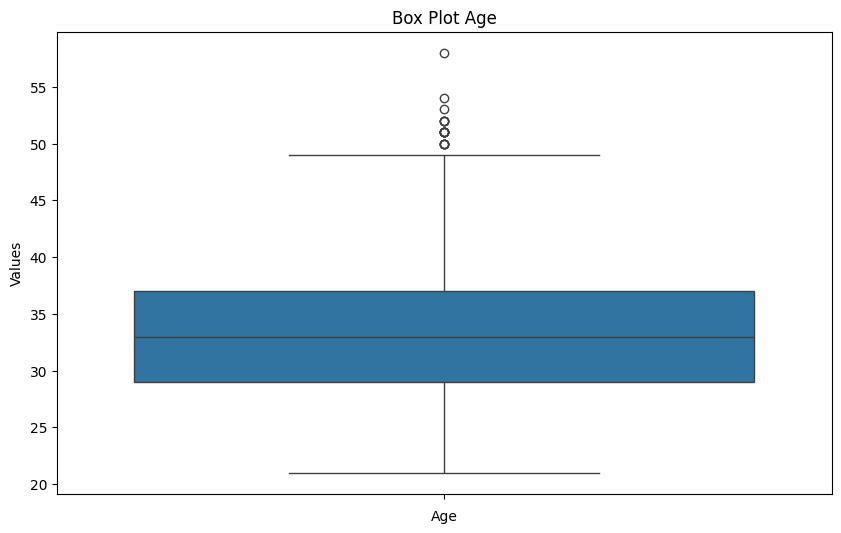

For Income:
Lower bound: -15887.5
Upper bound: 130756.5
Q1: 39104.0
Median: 55276.0
Q3: 75765.0
------------------------------


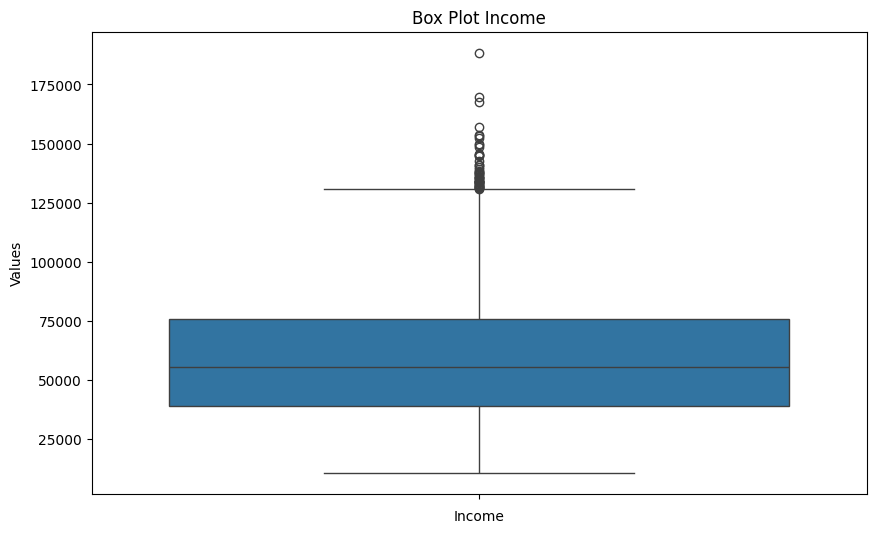

For Total Business Value:
Lower bound: -6260475.0
Upper bound: 10434125.0
Q1: 0.0
Median: 817680.0
Q3: 4173650.0
------------------------------


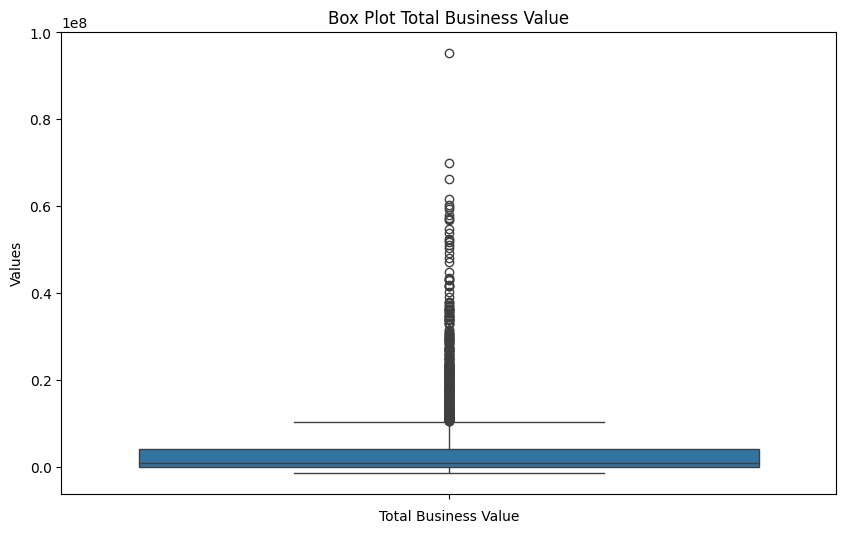

In [31]:
numerical_col = ['Age','Income','Total Business Value']
for k in numerical_col:
    # Set the size of the plot
    plt.figure(figsize=(10,6))

    # Create the box plot
    sns.boxplot(data = ola2[k])

    # Set the title and labels
    plt.title(f'Box Plot {k}')
    plt.xlabel(f"{k}")
    plt.ylabel('Values')

    # Calculate and print the statistics
    min_val = ola2[k].quantile(0)
    Q1 = ola2[k].quantile(0.25)
    median = ola2[k].median()
    Q3 = ola2[k].quantile(0.75)
    max_val = ola2[k].quantile(1)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"For {k}:")
    print(f"Lower bound: {lower_bound}")
    print(f"Upper bound: {upper_bound}")
    print(f"Q1: {Q1}")
    print(f"Median: {median}")
    print(f"Q3: {Q3}")
    print("---"*10)

    # Display the plot
    plt.show()



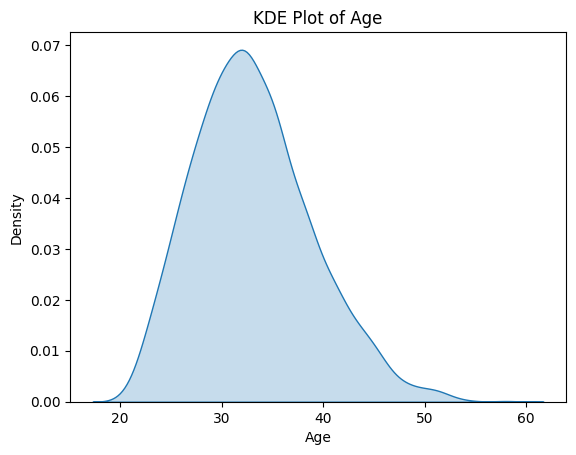

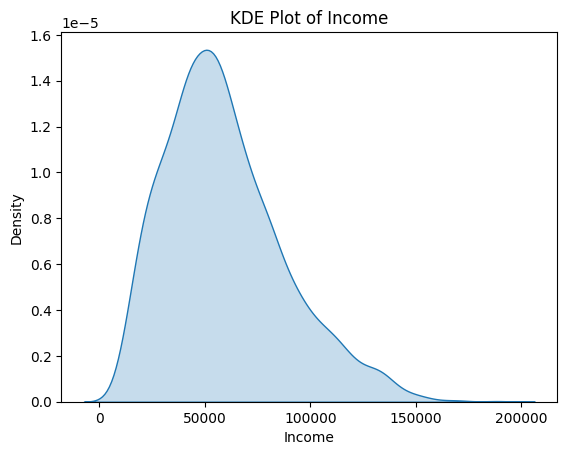

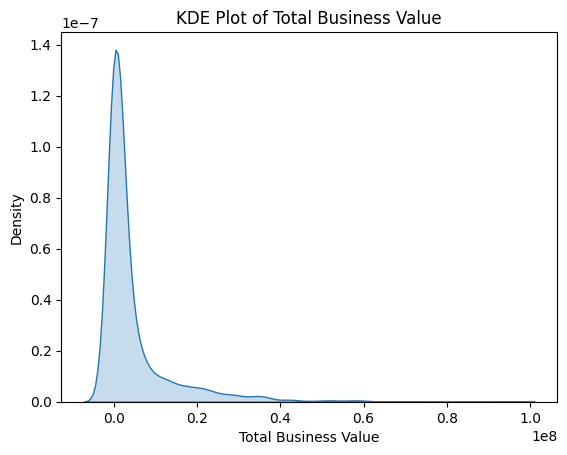

In [34]:
import seaborn as sns
numerical_col = ['Age','Income','Total Business Value']

for col in numerical_col:
    sns.kdeplot(ola2[col], fill=True)
    plt.title(f"KDE Plot of {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

In [ ]:
duplicated_rows = ola2[ola2.duplicated()]
print("Number of duplicate rows: ", duplicated_rows.shape[0])

Number of duplicate rows:  0


From the above we could see there are no duplicated rows

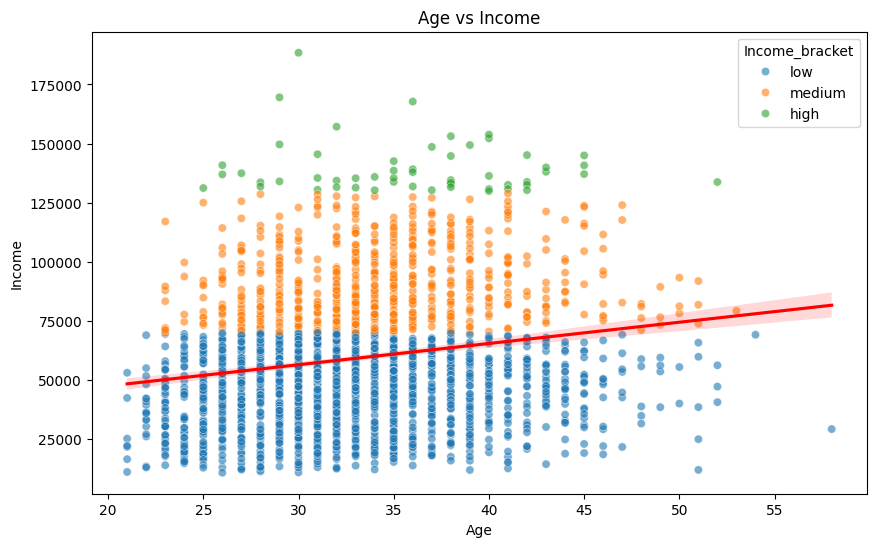

In [35]:
# Use different colors for different income brackets
income_brackets = ['low','medium','high']
ola2['Income_bracket'] = pd.cut(ola2['Income'],bins = 3,labels=income_brackets)

# Scatter plot for Age vs Income
plt.figure(figsize = (10,6))
sns.scatterplot(x='Age', y='Income',hue = 'Income_bracket',data = ola2,alpha=0.6)

# Add a trend line
sns.regplot(x = 'Age', y= 'Income', data = ola2, scatter=False, color='red')
plt.title('Age vs Income')
plt.show()

There appears to be a positive correlation between age and income, as indicated by the trend line. This suggests that, on average, income tends to increase with age.

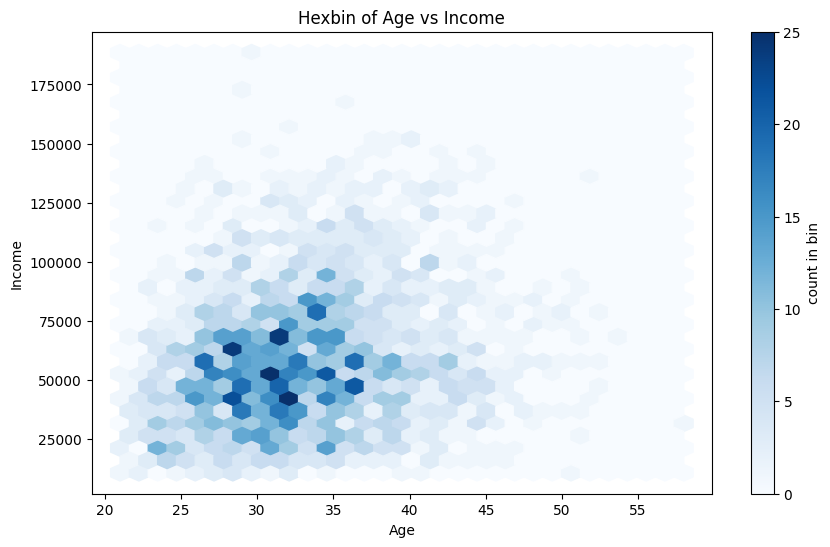

In [36]:
plt.figure(figsize=(10, 6))
plt.hexbin(ola2['Age'], ola2['Income'], gridsize=30, cmap='Blues')
cb = plt.colorbar(label='count in bin')
plt.title('Hexbin of Age vs Income')
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()


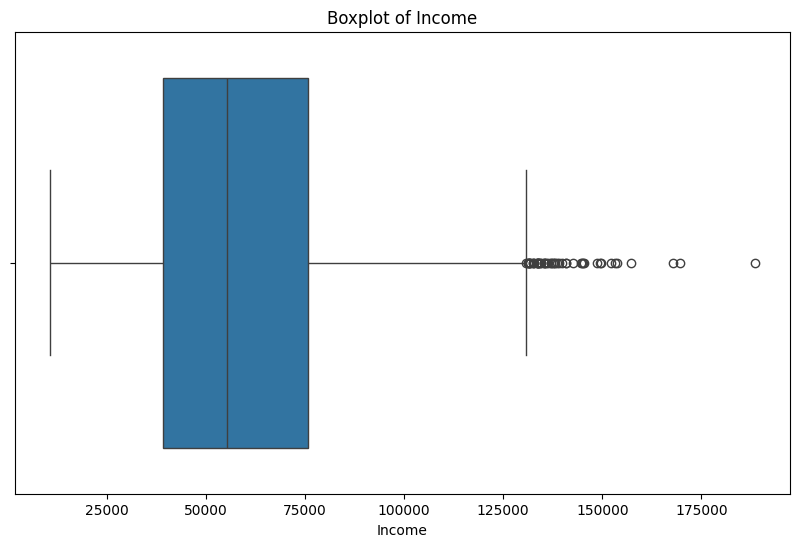

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=ola2['Income'])
plt.title('Boxplot of Income')
plt.show()


In [38]:
ola2['Age'].unique()

array([28., 31., 43., 29., 34., 35., 39., 30., 42., 27., 26., 33., 40.,
       41., 32., 22., 44., 36., 21., 49., 46., 25., 38., 37., 24., 45.,
       51., 48., 23., 47., 52., 50., 54., 58., 53.])

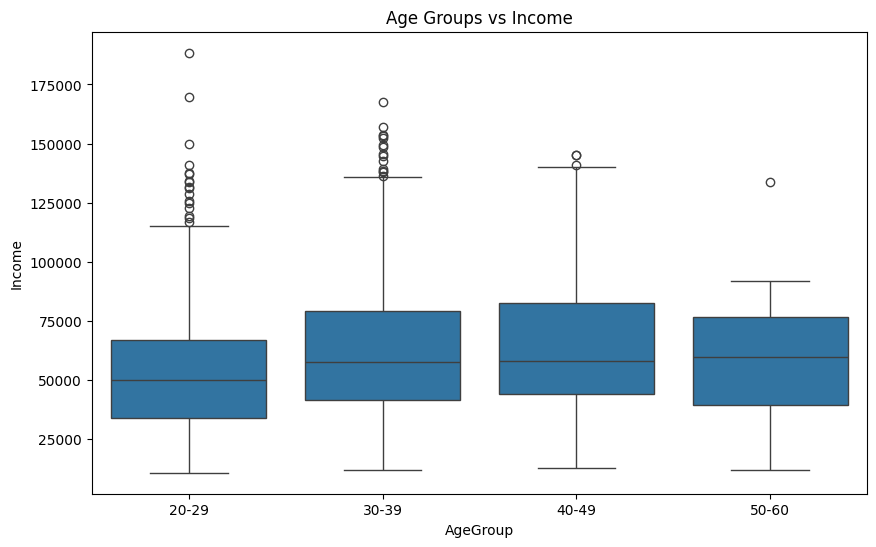

In [39]:
# Define age groups
bins = [20, 30, 40, 50, 60]
labels = ['20-29', '30-39', '40-49', '50-60']
ola2['AgeGroup'] = pd.cut(ola2['Age'], bins=bins, labels=labels)

# Boxplot for Age Groups vs Income
plt.figure(figsize=(10, 6))
sns.boxplot(x='AgeGroup', y='Income', data=ola2)
plt.title('Age Groups vs Income')
plt.show()


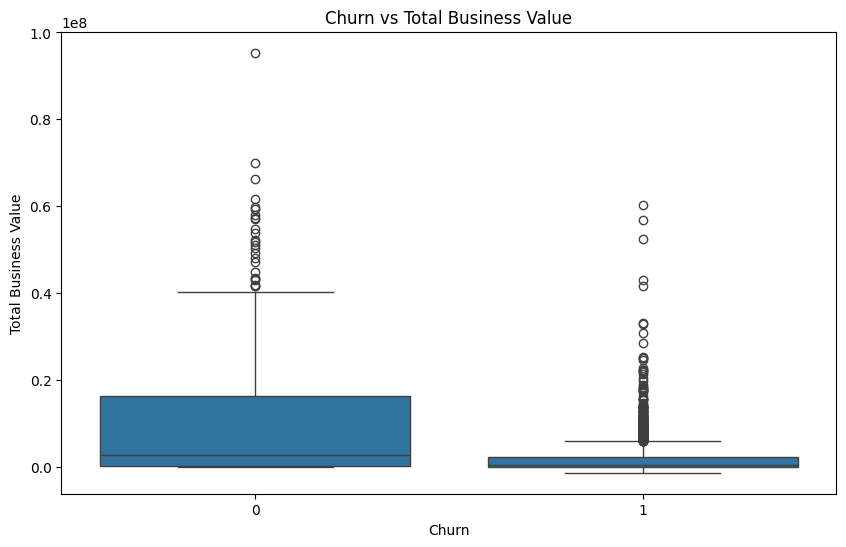

In [40]:
# Boxplot for Churn vs Total Business Value
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='Total Business Value', data=ola2)
plt.title('Churn vs Total Business Value')
plt.show()

In [41]:
# Calculate statistical information for 'Total Business Value'
for churn_value in ola2['Churn'].unique():
    subset = ola2[ola2['Churn'] == churn_value]['Total Business Value']
    Q1 = subset.quantile(0.25)
    median = subset.median()
    Q3 = subset.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_above = subset[subset > upper_bound]
    outliers_below = subset[subset < lower_bound]
    total_business_negative = subset[(subset < 0)]

    # Print results with color
    print(f"\033[1;34mStatistics for Churn = {churn_value}:\033[0m")
    print(f"  \033[1;32mQ1 (25th Percentile):\033[0m {Q1}")
    print(f"  \033[1;32mMedian (50th Percentile):\033[0m {median}")
    print(f"  \033[1;32mQ3 (75th Percentile):\033[0m {Q3}")
    print(f"  \033[1;32mIQR (Interquartile Range):\033[0m {IQR}")
    print(f"  \033[1;31mLower Bound:\033[0m {lower_bound}")
    print(f"  \033[1;31mUpper Bound:\033[0m {upper_bound}")
    print(f"  \033[1;33mOutliers Below Lower Bound:\033[0m {outliers_below.tolist()}")
    print(f"  \033[1;33mOutliers Above Upper Bound:\033[0m {outliers_above.tolist()}")
    print(f"  \033[1;33mtotal_business_negative:\033[0m {total_business_negative.tolist()}\n")

Statistics for Churn = 1:
  Q1 (25th Percentile): 0.0
  Median (50th Percentile): 465025.0
  Q3 (75th Percentile): 2345702.5
  IQR (Interquartile Range): 2345702.5
  Lower Bound: -3518553.75
  Upper Bound: 5864256.25
  Outliers Below Lower Bound: []
  Outliers Above Upper Bound: [10213040, 6962550, 7539490, 22791310, 11718580, 8688020, 6131430, 21415440, 6278140, 10395250, 9983020, 7020890, 7237950, 10390120, 11947410, 7912770, 6751230, 56839380, 9577580, 11082000, 13594350, 5875810, 10732480, 25128430, 6940080, 6644580, 11593960, 10289970, 9979710, 7596440, 7165360, 12922130, 11940020, 17244320, 13721360, 6705230, 7055630, 5936640, 7563910, 22269520, 13697710, 6576490, 8595450, 6521890, 9000520, 28562340, 13627070, 6883410, 8687010, 32819830, 5995150, 6967160, 10493340, 12941580, 6333350, 13942630, 15626920, 41669570, 9611290, 10479300, 9828090, 8494310, 6600380, 10885280, 9271700, 8684000, 9474670, 9214510, 7267150, 18340790, 7414770, 43100100, 14593130, 9411200, 7686550, 12476730, 8

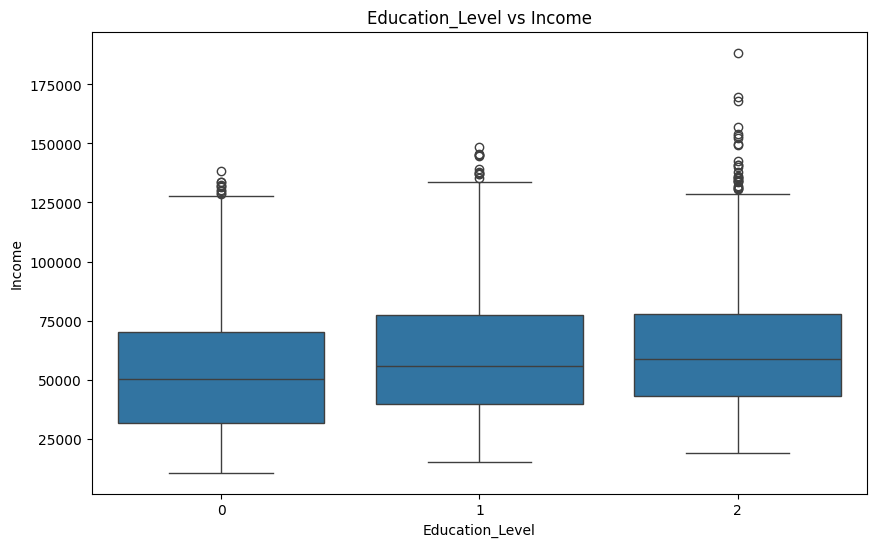

In [ ]:
# Boxplot for Education_level vs Income
plt.figure(figsize=(10,6))
sns.boxplot(x = 'Education_Level',y = 'Income', data = ola2)
plt.title('Education_Level vs Income')
plt.show()

In [42]:
# Group by 'Education_Level' and get descriptive statistics for 'Income'
income_stats = ola2.groupby('Education_Level')['Income'].describe()

# Print the statistics
print(income_stats[['min', '25%', '50%', '75%', 'max']])


                     min      25%      50%       75%       max
Education_Level                                               
0                10747.0  31871.5  50143.0  70227.50  138520.0
1                15189.0  39890.0  55857.0  77562.50  148588.0
2                19020.0  43189.5  58771.5  77754.25  188418.0


From the above we can see the median of all th three gorups which 54500 to 65000
Clearly we could see the the group 1 and 2 are making 5000 higher salary compared with the group 0.
We can say the educated drivers are making more money

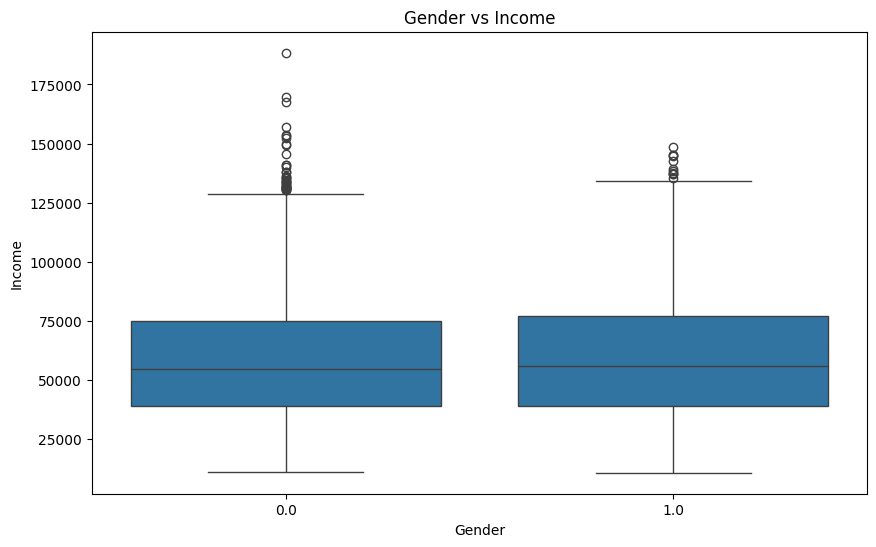

In [43]:
# Boxplot for Gender Vs Income
plt.figure(figsize=(10,6))
sns.boxplot(x ='Gender', y ='Income', data = ola2)
plt.title('Gender vs Income')
plt.show()

In [44]:
print(f'the median salary for male is {ola2.loc[ola2["Gender"] == 0]["Income"].median()}')
print(f'the median salary for female is {ola2.loc[ola2["Gender"] == 1]["Income"].median()}')

the median salary for male is 54681.0
the median salary for female is 55762.0


In [45]:
# Group by 'Gender' and get descriptive statistics for 'Income'
income_stats = ola2.groupby('Gender')['Income'].describe()

# Print the statistics
print(income_stats[['min', '25%', '50%', '75%', 'max']])

            min       25%      50%      75%       max
Gender                                               
0.0     11068.0  39104.25  54681.0  74965.0  188418.0
1.0     10747.0  39104.00  55762.0  77197.0  148588.0


The median,Q3 for Male is 59647,83084 and female is 61898,85450 which shows the median is slightly higher for female.
We could say the outliers are less for Female and Male has more outliers


In [46]:
ola2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Driver_ID             2381 non-null   int64   
 1   Age                   2381 non-null   float64 
 2   Gender                2381 non-null   float64 
 3   City                  2381 non-null   object  
 4   Education_Level       2381 non-null   int64   
 5   Income                2381 non-null   int64   
 6   Dateofjoining         2381 non-null   object  
 7   LastWorkingDate       1616 non-null   object  
 8   Joining Designation   2381 non-null   int64   
 9   Grade                 2381 non-null   int64   
 10  Total Business Value  2381 non-null   int64   
 11  Quarterly Rating      2381 non-null   float64 
 12  Rating_increase       2381 non-null   int64   
 13  Max_Rating            2381 non-null   int64   
 14  Min_rating            2381 non-null   int64   
 15  Chur

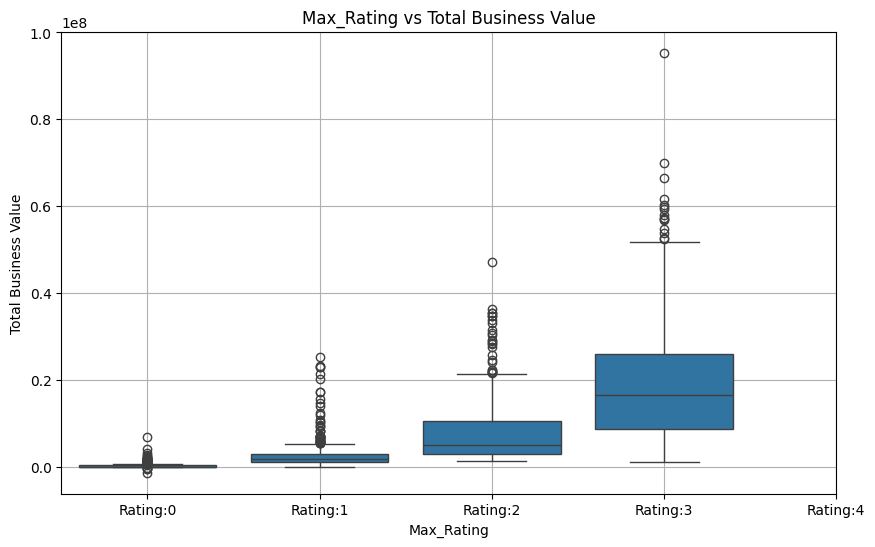

In [48]:
# Scatter plot for Quarterly Rating vs Total Business Value
plt.figure(figsize=(10,6))
sns.boxplot(x = 'Max_Rating', y = 'Total Business Value', data=ola2)
plt.title('Max_Rating vs Total Business Value')
plt.xlabel('Max_Rating')
plt.ylabel('Total Business Value')
plt.grid(True)

# Customizing x-axis Labels
rating_labels = ['Rating:0','Rating:1', 'Rating:2','Rating:3','Rating:4']
plt.xticks(ticks=[0,1,2,3,4],labels=rating_labels)

plt.show()

In [ ]:
print(f"The total businsess value contributed by people with max rating 1 is {ola2.loc[ola2['Max_Rating'] == 1]['Total Business Value'].sum()}")
print(f"The total businsess value contributed by people with average rating 1 is {round(ola2.loc[ola2['Max_Rating'] == 1]['Total Business Value'].mean(),2)}")
print(f"The total businsess value contributed by people with max rating 2 is {ola2.loc[ola2['Max_Rating'] == 2]['Total Business Value'].sum()}")
print(f"The total businsess value contributed by people with average rating 2 is {round(ola2.loc[ola2['Max_Rating'] == 2]['Total Business Value'].mean(),2)}")
print(f"The total businsess value contributed by people with max rating 3 is {ola2.loc[ola2['Max_Rating'] == 3]['Total Business Value'].sum()}")
print(f"The total businsess value contributed by people with average rating 3 is {round(ola2.loc[ola2['Max_Rating'] == 3]['Total Business Value'].mean(),2)}")
print(f"The total businsess value contributed by people with max rating 4 is {ola2.loc[ola2['Max_Rating'] == 4]['Total Business Value'].sum()}")
print(f"The total businsess value contributed by people with average rating 4 is {round(ola2.loc[ola2['Max_Rating'] == 4]['Total Business Value'].mean(),2)}")

The total businsess value contributed by people with max rating 1 is 224400220
The total businsess value contributed by people with average rating 1 is 186689.03
The total businsess value contributed by people with max rating 2 is 1261539390
The total businsess value contributed by people with average rating 2 is 2606486.34
The total businsess value contributed by people with max rating 3 is 2808196290
The total businsess value contributed by people with average rating 3 is 7910412.08
The total businsess value contributed by people with max rating 4 is 6626896380
The total businsess value contributed by people with average rating 4 is 19490871.71


We could see that the people with rating 3 and 4 are bringing very business value compared to the lower rating

* We could see that there 2085 drivers who contribute to a lower Rating 1and 982 have contributed  for 2 rating.
* Around 3000 drivers have contributed less business value and only 1000 drivers with rating of 3 and 4 have contributed to higher business value.

In [49]:
# Group by 'Quarterly Rating' and get number of unique 'Driver_ID'
unique_drivers_male_female = ola2.groupby('Gender')['Driver_ID'].nunique()

# Print the result
print(unique_drivers_male_female)

Gender
0.0    1404
1.0     977
Name: Driver_ID, dtype: int64


* We could see that there are 50 percent more Male Drivers than Female.

In [50]:
# Converting 'Dateofjoining' to datatime
ola2['Dateofjoining'] = pd.to_datetime(ola2['Dateofjoining'])

# Convert 'LastWorkingDate' to datetime
ola2['LastWorkingDate'] = pd.to_datetime(ola2['LastWorkingDate'])

In [ ]:
ola2['Dateofjoining'].unique()

<DatetimeArray>
['2018-12-24 00:00:00', '2020-11-06 00:00:00', '2019-12-07 00:00:00',
 '2019-01-09 00:00:00', '2020-07-31 00:00:00', '2020-09-19 00:00:00',
 '2020-12-07 00:00:00', '2019-06-29 00:00:00', '2015-05-28 00:00:00',
 '2020-10-16 00:00:00',
 ...
 '2019-06-16 00:00:00', '2020-10-20 00:00:00', '2014-10-17 00:00:00',
 '2013-07-08 00:00:00', '2015-08-29 00:00:00', '2017-06-12 00:00:00',
 '2020-01-26 00:00:00', '2020-02-17 00:00:00', '2019-05-16 00:00:00',
 '2020-08-28 00:00:00']
Length: 869, dtype: datetime64[ns]

In [51]:
ola2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             2381 non-null   int64         
 1   Age                   2381 non-null   float64       
 2   Gender                2381 non-null   float64       
 3   City                  2381 non-null   object        
 4   Education_Level       2381 non-null   int64         
 5   Income                2381 non-null   int64         
 6   Dateofjoining         2381 non-null   datetime64[ns]
 7   LastWorkingDate       1616 non-null   datetime64[ns]
 8   Joining Designation   2381 non-null   int64         
 9   Grade                 2381 non-null   int64         
 10  Total Business Value  2381 non-null   int64         
 11  Quarterly Rating      2381 non-null   float64       
 12  Rating_increase       2381 non-null   int64         
 13  Max_Rating        

In [52]:
# Define a reference date for those still working
reference_date = pd.to_datetime('2020-12-31')

# Calculate years of work
ola2['YearsofWork'] = ola2.apply(

  lambda row: (row['LastWorkingDate'] - row['Dateofjoining']).days / 365.25
  if pd.notnull(row['LastWorkingDate'])
  else (reference_date - row['Dateofjoining']).days / 365.25,
  axis=1
)

In [53]:
# Define a reference date for those still working
reference_date = pd.to_datetime('2020-12-31')

# Calculate months of work
ola2['MonthsOfWork'] = ola2.apply(
    lambda row: (row['LastWorkingDate'] - row['Dateofjoining']).days / 30.44
    if pd.notnull(row['LastWorkingDate'])
    else (reference_date - row['Dateofjoining']).days / 30.44,
    axis=1
)


In [54]:
ola2['MonthsOfWork'] = round(ola2['MonthsOfWork'].astype(int),2)

In [55]:
ola2['MonthsOfWork']

,MonthsOfWork
0,2
1,1
2,4
3,1
4,5
...,...
2376,62
2377,2
2378,13
2379,10


In [56]:
ola2['YearsofWork'].shape

(2381,)

In [57]:
ola2['YearsofWork'].dtype

dtype('float64')

In [58]:
ola2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             2381 non-null   int64         
 1   Age                   2381 non-null   float64       
 2   Gender                2381 non-null   float64       
 3   City                  2381 non-null   object        
 4   Education_Level       2381 non-null   int64         
 5   Income                2381 non-null   int64         
 6   Dateofjoining         2381 non-null   datetime64[ns]
 7   LastWorkingDate       1616 non-null   datetime64[ns]
 8   Joining Designation   2381 non-null   int64         
 9   Grade                 2381 non-null   int64         
 10  Total Business Value  2381 non-null   int64         
 11  Quarterly Rating      2381 non-null   float64       
 12  Rating_increase       2381 non-null   int64         
 13  Max_Rating        

In [59]:
list(ola2.columns)

['Driver_ID',
 'Age',
 'Gender',
 'City',
 'Education_Level',
 'Income',
 'Dateofjoining',
 'LastWorkingDate',
 'Joining Designation',
 'Grade',
 'Total Business Value',
 'Quarterly Rating',
 'Rating_increase',
 'Max_Rating',
 'Min_rating',
 'Churn',
 'Income_bracket',
 'AgeGroup',
 'YearsofWork',
 'MonthsOfWork']

In [60]:
catcol2 = ['Gender', 'Education_Level', 'Income_bracket', 'AgeGroup']

for cat in catcol2:
    # Group by 'Education_Level' and get descriptive statistics for 'Income'
    tbv_stats = ola2.groupby(cat)['Total Business Value'].describe()

    # Print the statistics
    print(f"{cat} vs Total Business Value:", tbv_stats[['min', '25%', '50%', '75%', 'max']])

Gender vs Total Business Value:               min  25%       50%        75%         max
Gender                                                 
0.0    -1385530.0  0.0  743460.0  4138325.0  69867900.0
1.0     -645150.0  0.0  942130.0  4277730.0  95331060.0
Education_Level vs Total Business Value:                        min  25%        50%        75%         max
Education_Level                                                  
0                -645150.0  0.0   583120.0  3246245.0  59696450.0
1                -411250.0  0.0  1052990.0  4613920.0  95331060.0
2               -1385530.0  0.0   865335.0  4523627.5  69867900.0
Income_bracket vs Total Business Value:                       min        25%         50%         75%         max
Income_bracket                                                          
low            -1385530.0        0.0    522630.0   2665685.0  41667690.0
medium          -411250.0   108917.5   1835165.0   9517225.0  95331060.0
high                  0.0  1051240.0  123

In [ ]:
ola2['Dateofjoining'].unique()

<DatetimeArray>
['2018-12-24 00:00:00', '2020-11-06 00:00:00', '2019-12-07 00:00:00',
 '2019-01-09 00:00:00', '2020-07-31 00:00:00', '2020-09-19 00:00:00',
 '2020-12-07 00:00:00', '2019-06-29 00:00:00', '2015-05-28 00:00:00',
 '2020-10-16 00:00:00',
 ...
 '2019-06-16 00:00:00', '2020-10-20 00:00:00', '2014-10-17 00:00:00',
 '2013-07-08 00:00:00', '2015-08-29 00:00:00', '2017-06-12 00:00:00',
 '2020-01-26 00:00:00', '2020-02-17 00:00:00', '2019-05-16 00:00:00',
 '2020-08-28 00:00:00']
Length: 869, dtype: datetime64[ns]

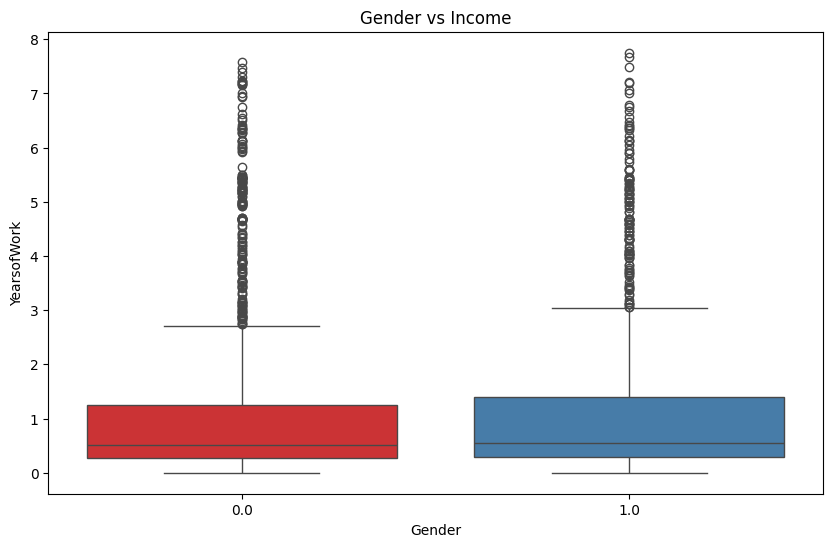

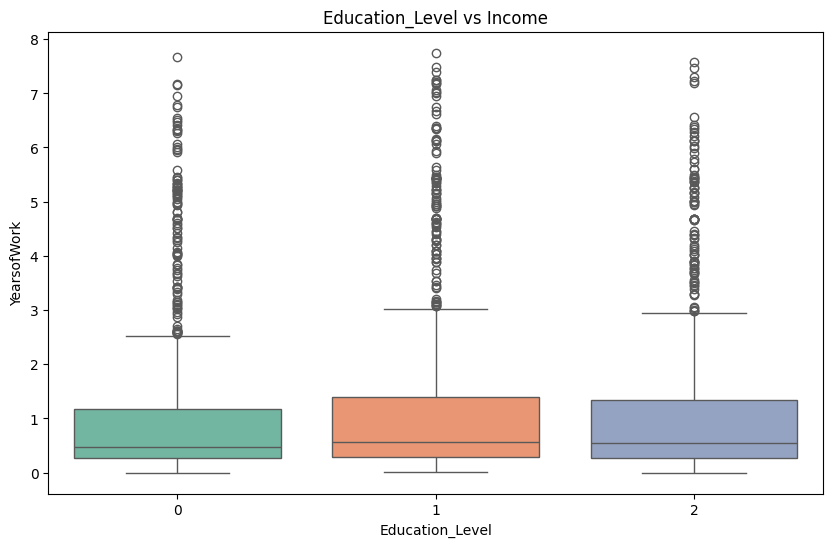

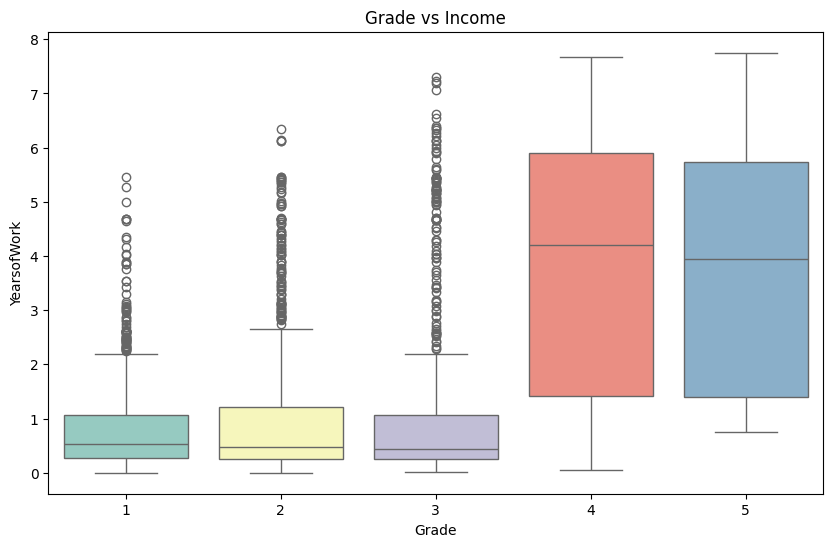

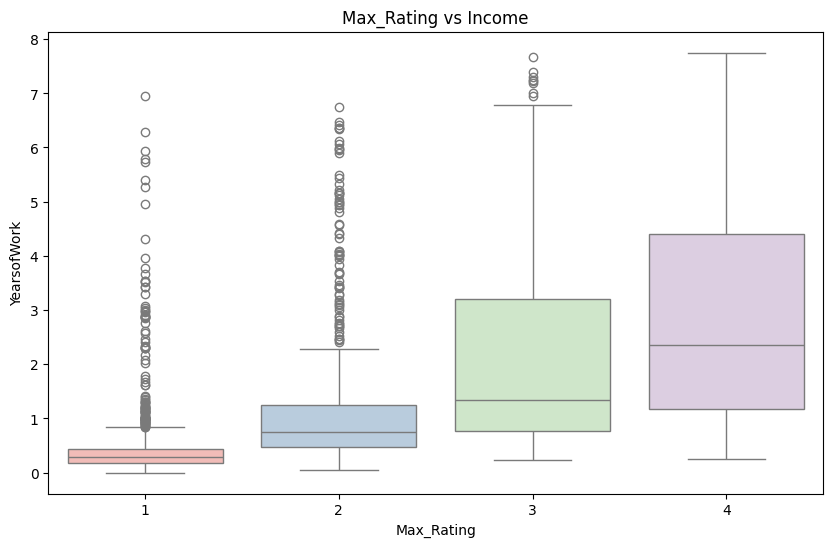

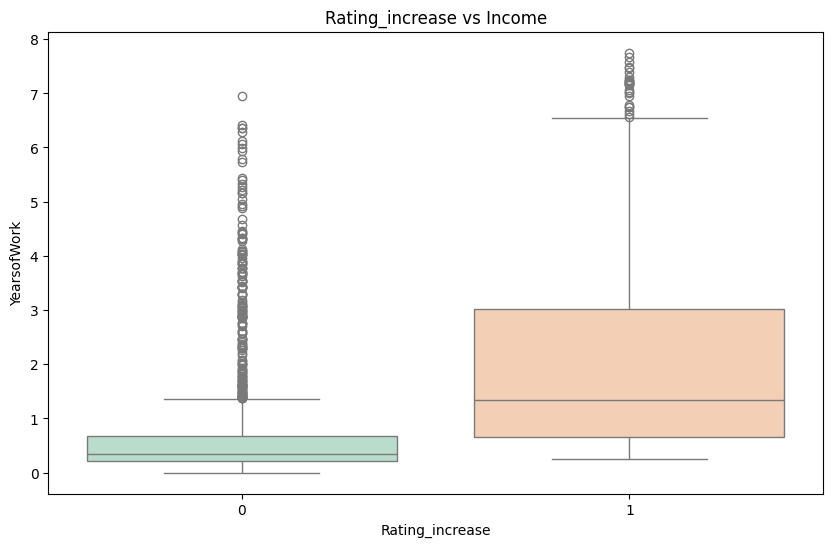

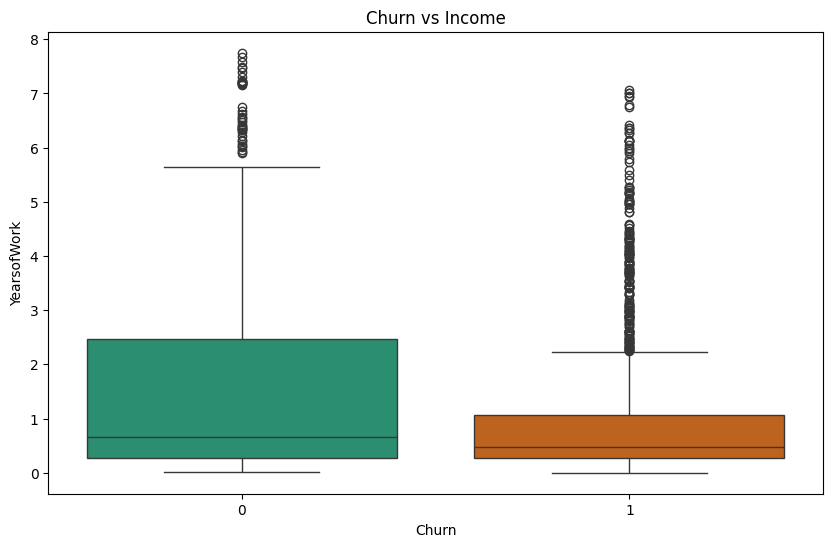

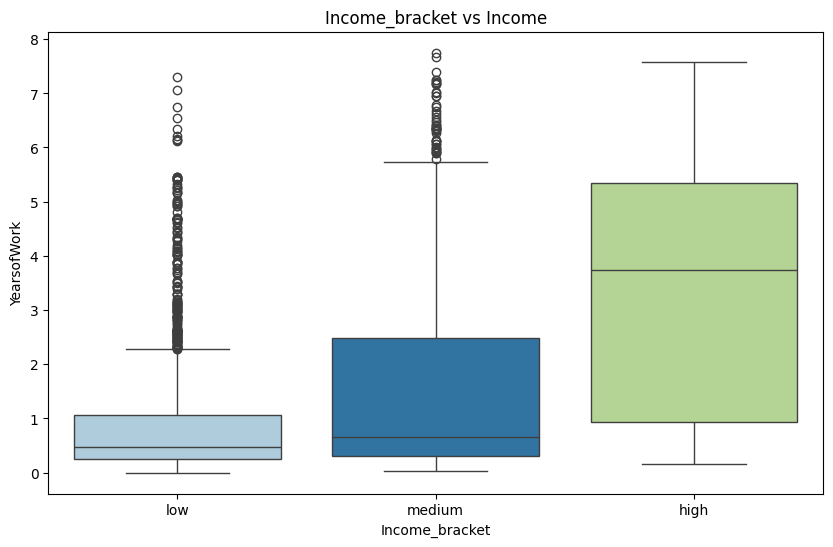

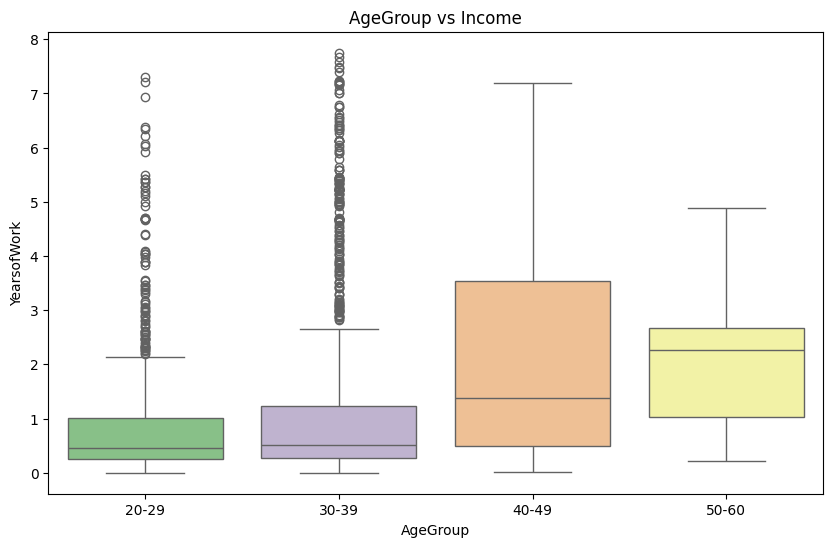

In [64]:
catcol = ['Gender','Education_Level','Grade','Max_Rating','Rating_increase','Churn','Income_bracket','AgeGroup']
color_palettes = [
    'Set1', 'Set2', 'Set3', 'Pastel1', 'Pastel2', 'Dark2', 'Paired', 'Accent'
]
# Boxplot for years of work
for i,cat in enumerate(catcol):
  plt.figure(figsize=(10,6))
  sns.boxplot(x = cat,y = 'YearsofWork', data = ola2,palette=color_palettes[i % len(color_palettes)])
  plt.title(f'{cat} vs Income')
  plt.show()

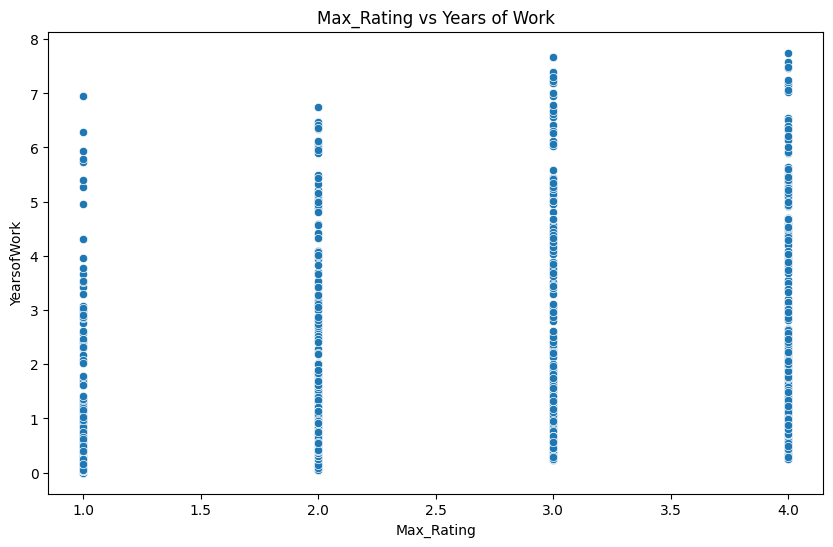

In [66]:
# Scatter plot for Quarterly Rating vs YearsOfWork
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Max_Rating', y='YearsofWork', data=ola2, palette = 'set3')
plt.title('Max_Rating vs Years of Work')
plt.show()

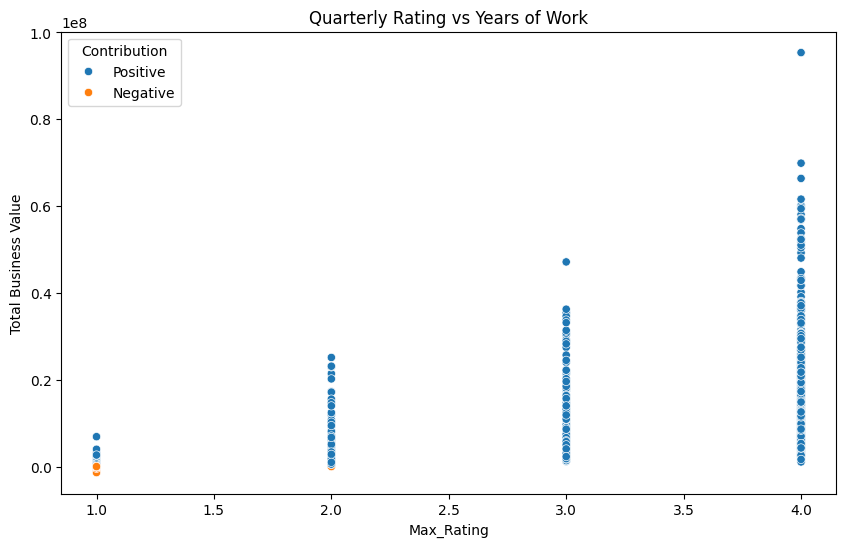

In [67]:
# Create a new column 'Contribution' based on 'Total Business Value'
ola2['Contribution'] = ola2['Total Business Value'].apply(lambda x: 'Positive' if x>0 else 'Negative')

#Scatter plot for quarterly Rating vs yearofWork with color encoding based on 'Contribution'
plt.figure(figsize=(10,6))
sns.scatterplot(x='Max_Rating', y='Total Business Value', hue='Contribution', data=ola2)
plt.title('Quarterly Rating vs Years of Work')
plt.show()

* We could see from the above two graphs the drivers who had low rating and have contributed negative to the business have left

In [68]:
churn_data = ola2[ola2['YearsofWork'].notna()].groupby(['YearsofWork','Max_Rating']).size().reset_index(name='Drivers_Left')

#Display the table
print(churn_data)

      YearsofWork  Max_Rating  Drivers_Left
0        0.000000           1             4
1        0.008214           1             2
2        0.010951           1             1
3        0.016427           1             3
4        0.019165           1             1
...           ...         ...           ...
1259     7.468857           4             1
1260     7.482546           4             1
1261     7.581109           4             1
1262     7.663244           3             1
1263     7.750856           4             1

[1264 rows x 3 columns]


In [69]:
ola2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             2381 non-null   int64         
 1   Age                   2381 non-null   float64       
 2   Gender                2381 non-null   float64       
 3   City                  2381 non-null   object        
 4   Education_Level       2381 non-null   int64         
 5   Income                2381 non-null   int64         
 6   Dateofjoining         2381 non-null   datetime64[ns]
 7   LastWorkingDate       1616 non-null   datetime64[ns]
 8   Joining Designation   2381 non-null   int64         
 9   Grade                 2381 non-null   int64         
 10  Total Business Value  2381 non-null   int64         
 11  Quarterly Rating      2381 non-null   float64       
 12  Rating_increase       2381 non-null   int64         
 13  Max_Rating        

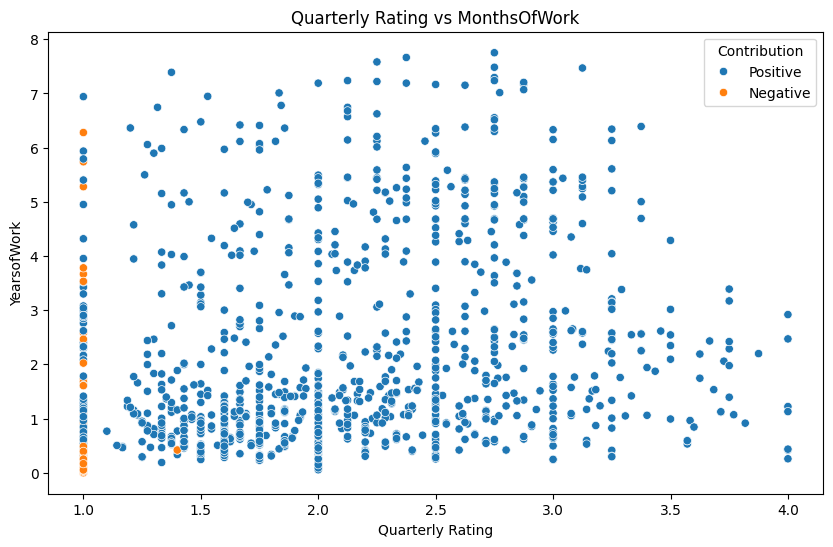

In [70]:
#Scatter plot for quarterly Rating vs MonthsOfWork with color encoding based on 'Contribution'
plt.figure(figsize=(10,6))
sns.scatterplot(x='Quarterly Rating', y='YearsofWork', hue='Contribution', data=ola2)
plt.title('Quarterly Rating vs MonthsOfWork')
plt.show()

* We could see that the drivers wit hthe lowest rating has contibuted negtively to the business iresspective of the months worked

In [71]:
ola2.isnull().sum()

,0
Driver_ID,0
Age,0
Gender,0
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,765
Joining Designation,0
Grade,0


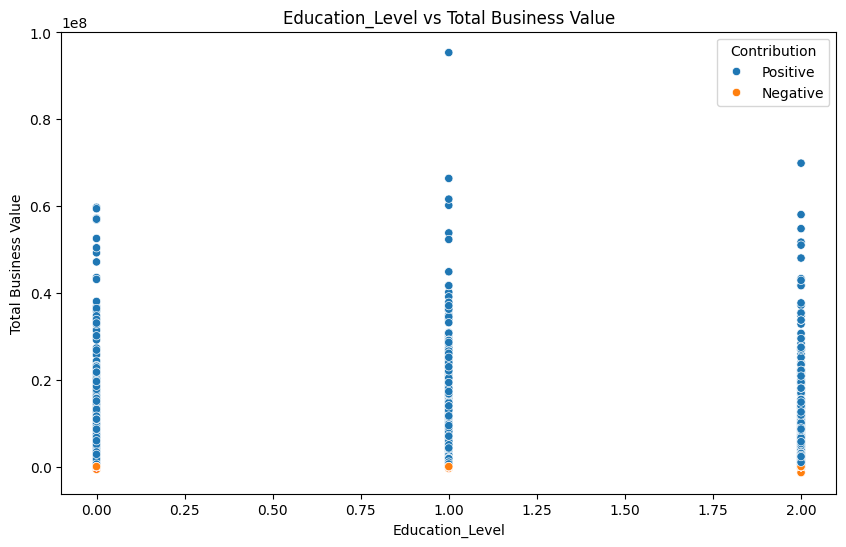

In [72]:
#Scatter plot for quarterly Rating vs yearofWork with color encoding based on 'Contribution'
plt.figure(figsize=(10,6))
sns.scatterplot(x='Education_Level', y='Total Business Value', hue='Contribution', data=ola2)
plt.title('Education_Level vs Total Business Value')
plt.show()

* We could see that there are more positive contributors irrespective of the age

In [73]:
# Select numerical columns
numerical_cols = ['Age', 'Gender', 'Education_Level', 'Income', 'Joining Designation', 'Grade', 'Total Business Value', 'Quarterly Rating', 'YearsofWork']

# Calculate correlation matrix
corr_matrix = ola2[numerical_cols].corr()

#Print the correlation matrix
print(corr_matrix)

                           Age    Gender  Education_Level    Income  \
Age                   1.000000  0.031198        -0.009309  0.185667   
Gender                0.031198  1.000000        -0.008773  0.006852   
Education_Level      -0.009309 -0.008773         1.000000  0.140903   
Income                0.185667  0.006852         0.140903  1.000000   
Joining Designation   0.099843 -0.046056         0.003203  0.484837   
Grade                 0.224703 -0.006173        -0.014046  0.738378   
Total Business Value  0.192284  0.017560         0.001392  0.365867   
Quarterly Rating      0.163885  0.000278         0.037169  0.185847   
YearsofWork           0.250972  0.023402         0.006801  0.331149   

                      Joining Designation     Grade  Total Business Value  \
Age                              0.099843  0.224703              0.192284   
Gender                          -0.046056 -0.006173              0.017560   
Education_Level                  0.003203 -0.014046       

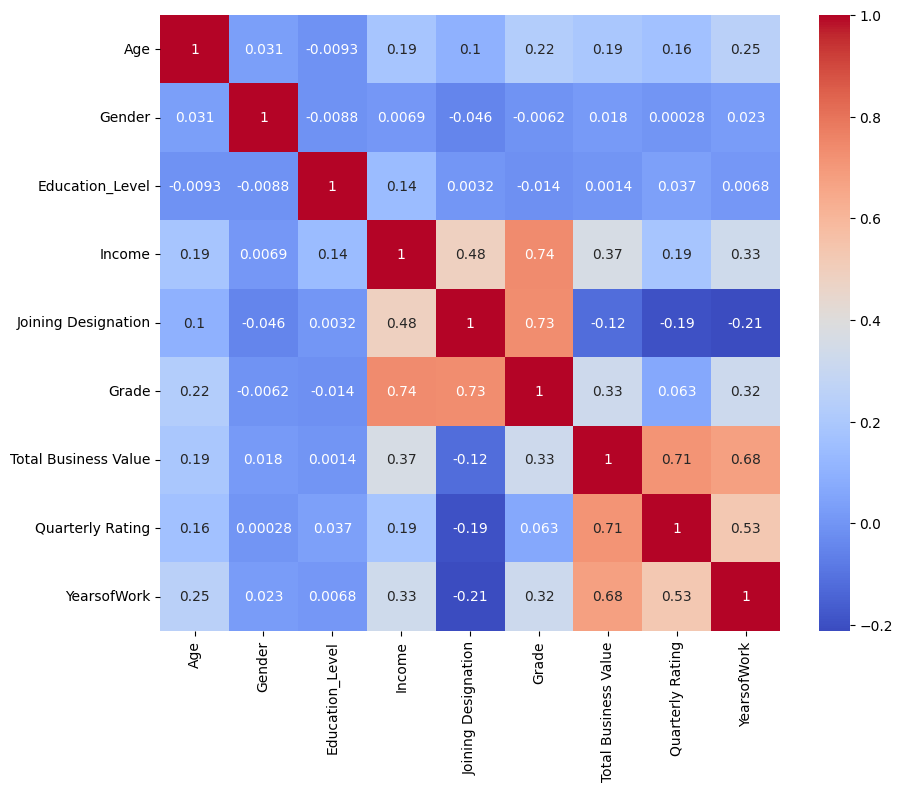

In [74]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot = True, cmap='coolwarm')
plt.show()

* ‘Income’ has a strong positive correlation with ‘Total Business Value’. This suggests that drivers with higher income tend to bring more business value.

* ‘Age’ has a moderate positive correlation with ‘Total Business Value’ and ‘Quarterly Rating’. This could indicate that older drivers tend to perform better and bring more business value.

* ‘Joining Designation’ has a negative correlation with ‘MonthsOfWork’. This might suggest that drivers who joined with a higher designation tend to work for fewer months.

In [75]:
ola1 = ola2.copy()

* Now we have aggregated the data set by goruping base on Driver_ID

In [93]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [76]:
# Correlation among independent variables
correlation_matrix = ola1[['Age','Income','Total Business Value','Quarterly Rating','Education_Level','YearsofWork']].corr()
print("\n Correlation Matirx:")
print(correlation_matrix)


 Correlation Matirx:
                           Age    Income  Total Business Value  \
Age                   1.000000  0.185667              0.192284   
Income                0.185667  1.000000              0.365867   
Total Business Value  0.192284  0.365867              1.000000   
Quarterly Rating      0.163885  0.185847              0.712487   
Education_Level      -0.009309  0.140903              0.001392   
YearsofWork           0.250972  0.331149              0.676545   

                      Quarterly Rating  Education_Level  YearsofWork  
Age                           0.163885        -0.009309     0.250972  
Income                        0.185847         0.140903     0.331149  
Total Business Value          0.712487         0.001392     0.676545  
Quarterly Rating              1.000000         0.037169     0.529165  
Education_Level               0.037169         1.000000     0.006801  
YearsofWork                   0.529165         0.006801     1.000000  


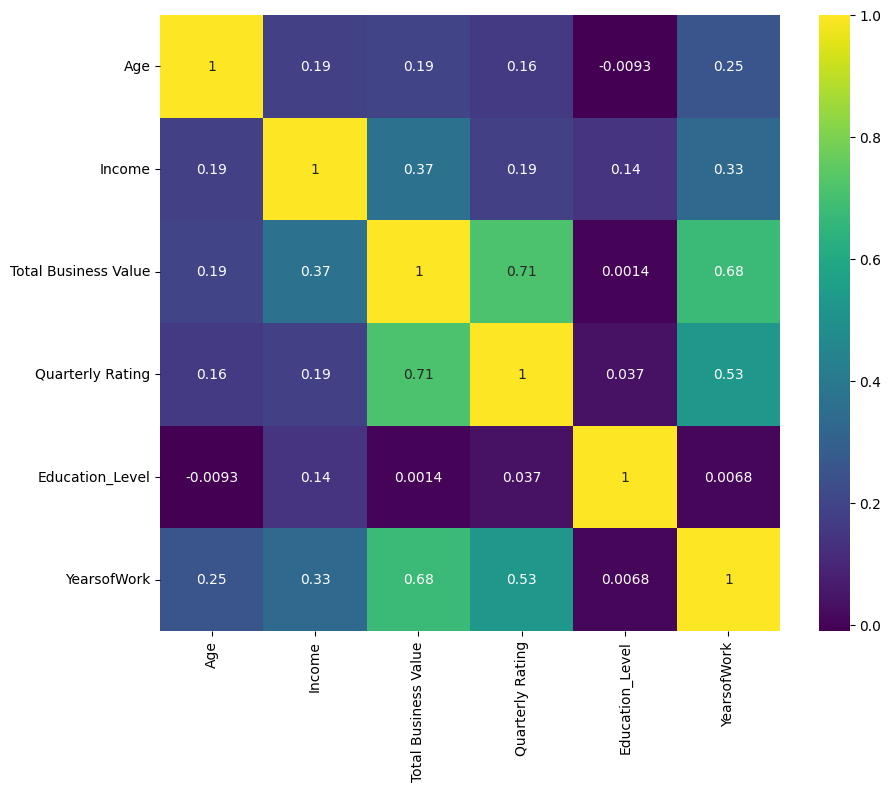

In [77]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot = True, cmap='viridis')
plt.show()

* We could see that Total business value and quarterly rating are highly correlated.
* However Years of work has a slightly lower correlation with respect to total business value with a value 0.68 and a 0.53 correlation with quarterly rating.

In [78]:
ola1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             2381 non-null   int64         
 1   Age                   2381 non-null   float64       
 2   Gender                2381 non-null   float64       
 3   City                  2381 non-null   object        
 4   Education_Level       2381 non-null   int64         
 5   Income                2381 non-null   int64         
 6   Dateofjoining         2381 non-null   datetime64[ns]
 7   LastWorkingDate       1616 non-null   datetime64[ns]
 8   Joining Designation   2381 non-null   int64         
 9   Grade                 2381 non-null   int64         
 10  Total Business Value  2381 non-null   int64         
 11  Quarterly Rating      2381 non-null   float64       
 12  Rating_increase       2381 non-null   int64         
 13  Max_Rating        

In [79]:
ola1 = ola1.drop(columns = ['Driver_ID','Dateofjoining','LastWorkingDate','Age','Quarterly Rating','Min_rating'])

In [80]:
ola1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Gender                2381 non-null   float64 
 1   City                  2381 non-null   object  
 2   Education_Level       2381 non-null   int64   
 3   Income                2381 non-null   int64   
 4   Joining Designation   2381 non-null   int64   
 5   Grade                 2381 non-null   int64   
 6   Total Business Value  2381 non-null   int64   
 7   Rating_increase       2381 non-null   int64   
 8   Max_Rating            2381 non-null   int64   
 9   Churn                 2381 non-null   int64   
 10  Income_bracket        2381 non-null   category
 11  AgeGroup              2381 non-null   category
 12  YearsofWork           2381 non-null   float64 
 13  MonthsOfWork          2381 non-null   int64   
 14  Contribution          2381 non-null   object  
dtypes: c

In [81]:
ola1[['City','Income_bracket','AgeGroup','Contribution']]

,City,Income_bracket,AgeGroup,Contribution
0,C23,low,20-29,Positive
1,C7,low,30-39,Negative
2,C13,low,40-49,Positive
3,C9,low,20-29,Positive
4,C11,medium,30-39,Positive
...,...,...,...,...
2376,C24,medium,30-39,Positive
2377,C9,low,30-39,Negative
2378,C19,low,40-49,Positive
2379,C20,low,20-29,Positive


In [ ]:
print(ola1['City'].unique())
print(ola1['Income_bracket'].unique())
print(ola1['AgeGroup'].unique())
print(ola1['Contribution'].unique())

['C23' 'C7' 'C13' 'C9' 'C11' 'C2' 'C19' 'C26' 'C20' 'C17' 'C29' 'C10'
 'C24' 'C14' 'C6' 'C28' 'C5' 'C18' 'C27' 'C15' 'C8' 'C25' 'C21' 'C1' 'C4'
 'C3' 'C16' 'C22' 'C12']
['low', 'medium', 'high']
Categories (3, object): ['low' < 'medium' < 'high']
['20-29', '30-39', '40-49', '50-60']
Categories (4, object): ['20-29' < '30-39' < '40-49' < '50-60']
['Positive' 'Negative']


In [ ]:
ola1['Churn']

,Churn
0,1
1,0
2,1
3,1
4,0
...,...
2376,0
2377,1
2378,1
2379,1


In [82]:
# Target encoding for the 'City' column with respect to 'Churn'
city_mean_mapping = ola1.groupby('City')['Churn'].mean()
ola1['City_Encoded'] = ola1['City'].map(city_mean_mapping)

# Display the first few rows to verify
print(ola1[['City', 'City_Encoded']].head())

  City  City_Encoded
0  C23      0.770270
1   C7      0.684211
2  C13      0.816901
3   C9      0.706667
4  C11      0.703125


In [83]:
# mapping for 'income_bracket'
incoming_bracket_mapping = {'low':0, 'medium':1, 'high':2}
ola1['Income_bracket_Encoded'] = ola1['Income_bracket'].map(incoming_bracket_mapping)

# Mapping for 'AgeGroup'
age_group_mapping = {'20-29': 0, '30-39': 1, '40-49': 2, '50-60': 3}
ola1['AgeGroup_Encoded'] = ola1['AgeGroup'].map(age_group_mapping)

# Mapping for 'Contribution'
contribution_mapping = {'Positive': 0, 'Negative': 1}
ola1['Contribution_Encoded'] = ola1['Contribution'].map(contribution_mapping)

In [84]:
ola1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Gender                  2381 non-null   float64 
 1   City                    2381 non-null   object  
 2   Education_Level         2381 non-null   int64   
 3   Income                  2381 non-null   int64   
 4   Joining Designation     2381 non-null   int64   
 5   Grade                   2381 non-null   int64   
 6   Total Business Value    2381 non-null   int64   
 7   Rating_increase         2381 non-null   int64   
 8   Max_Rating              2381 non-null   int64   
 9   Churn                   2381 non-null   int64   
 10  Income_bracket          2381 non-null   category
 11  AgeGroup                2381 non-null   category
 12  YearsofWork             2381 non-null   float64 
 13  MonthsOfWork            2381 non-null   int64   
 14  Contribution            

In [85]:
# Drop the original columns
ola1.drop(columns=['City', 'AgeGroup', 'Income_bracket', 'Contribution'], inplace=True)

# Rename the encoded columns
ola1.rename(columns={
    'City_Encoded': 'City',
    'Income_bracket_Encoded': 'Income_bracket',
    'AgeGroup_Encoded': 'AgeGroup',
    'Contribution_Encoded': 'Contribution'
}, inplace=True)

# Display the first few rows to verify
print(ola1.head())

   Gender  Education_Level  Income  Joining Designation  Grade  \
0     0.0                2   57387                    1      1   
1     0.0                2   67016                    2      2   
2     0.0                2   65603                    2      2   
3     0.0                0   46368                    1      1   
4     1.0                1   78728                    3      3   

   Total Business Value  Rating_increase  Max_Rating  Churn  YearsofWork  \
0               1715580                0           2      1     0.210815   
1                     0                0           1      0     0.150582   
2                350000                0           1      1     0.388775   
3                120360                0           1      1     0.156057   
4               1265000                1           2      0     0.418891   

   MonthsOfWork      City Income_bracket AgeGroup  Contribution  
0             2  0.770270              0        0             0  
1             

In [86]:
ola1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Gender                2381 non-null   float64 
 1   Education_Level       2381 non-null   int64   
 2   Income                2381 non-null   int64   
 3   Joining Designation   2381 non-null   int64   
 4   Grade                 2381 non-null   int64   
 5   Total Business Value  2381 non-null   int64   
 6   Rating_increase       2381 non-null   int64   
 7   Max_Rating            2381 non-null   int64   
 8   Churn                 2381 non-null   int64   
 9   YearsofWork           2381 non-null   float64 
 10  MonthsOfWork          2381 non-null   int64   
 11  City                  2381 non-null   float64 
 12  Income_bracket        2381 non-null   category
 13  AgeGroup              2381 non-null   category
 14  Contribution          2381 non-null   int64   
dtypes: c

In [87]:
ola1['Gender'] = ola1['Gender'].astype(int)

In [88]:
ola1['Income_bracket'] = ola1['Income_bracket'].astype(int)
ola1['AgeGroup'] = ola1['AgeGroup'].astype(int)

In [89]:
# Ensure the target variable and feature matrix are correctly defined
y = ola1['Churn']
X = ola1.drop(columns=['Churn'])  # Drop ID column and target column from features

In [90]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

In [91]:
ola1.shape

(2381, 15)

In [92]:
y_sm.value_counts()

,count
Churn,
1,1616
0,1616


In [94]:
# Standardization of training data
scaler = StandardScaler()
X_res_scaled_sc = scaler.fit_transform(X_sm)

# Convert scaled array back to DataFrame for statsmodels
X_res_scaled_df = pd.DataFrame(X_res_scaled_sc, columns=X.columns)


# Standardization of training data
scaler_m = MinMaxScaler()
X_res_scaled_mm = scaler_m.fit_transform(X_sm)

# Convert scaled array back to DataFrame for statsmodels
X_res_scaled_dfm = pd.DataFrame(X_res_scaled_mm, columns=X.columns)

Optimization terminated successfully.
         Current function value: 0.494526
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 2585
Model:                          Logit   Df Residuals:                     2570
Method:                           MLE   Df Model:                           14
Date:                Wed, 08 Jan 2025   Pseudo R-squ.:                  0.2865
Time:                        14:06:27   Log-Likelihood:                -1278.3
converged:                       True   LL-Null:                       -1791.8
Covariance Type:            nonrobust   LLR p-value:                2.692e-210
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.3494      0.064     -5.451      0.000      -0.475      -0.224

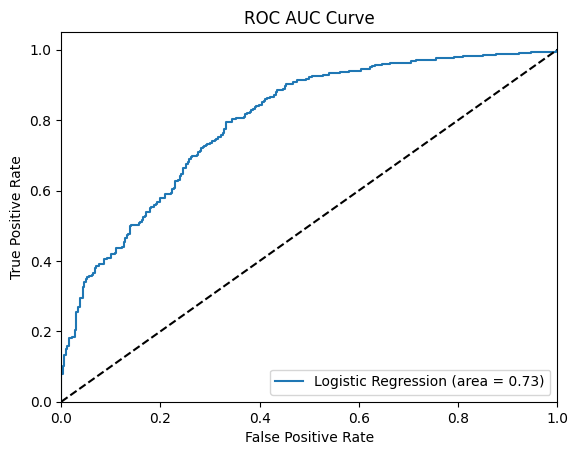


Actionable Insights & Recommendations:
1. Focus on retention strategies for drivers with increasing quarterly ratings.
2. Consider incentive programs for drivers with stable or increasing income.
3. Address potential reasons for attrition among drivers with higher target scores.
4. Analyze and improve working conditions in cities with higher attrition rates.


In [95]:


# Add a constant to the model (intercept term)
X_res_scaled_df = sm.add_constant(X_res_scaled_df)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res_scaled_df, y_sm, test_size=0.2, random_state=42)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Print the summary of the model
print(result.summary())

# Predicting on the test set
y_pred_prob = result.predict(X_test)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_prob]

# Classification Report and ROC AUC score
from sklearn.metrics import classification_report, roc_auc_score

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc_logit = roc_auc_score(y_test, y_pred)
print("ROC AUC Score for Logistic Regression: {:.2f}".format(roc_auc_logit))

# Plotting ROC AUC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_logit, tpr_logit, _ = roc_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr_logit, tpr_logit, label='Logistic Regression (area = %0.2f)' % roc_auc_logit)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

# Actionable Insights & Recommendations
print("\nActionable Insights & Recommendations:")
print("1. Focus on retention strategies for drivers with increasing quarterly ratings.")
print("2. Consider incentive programs for drivers with stable or increasing income.")
print("3. Address potential reasons for attrition among drivers with higher target scores.")
print("4. Analyze and improve working conditions in cities with higher attrition rates.")



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       326
           1       0.81      0.80      0.81       321

    accuracy                           0.81       647
   macro avg       0.81      0.81      0.81       647
weighted avg       0.81      0.81      0.81       647

ROC AUC Score for Random Forest: 0.81

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       326
           1       0.80      0.81      0.80       321

    accuracy                           0.80       647
   macro avg       0.80      0.80      0.80       647
weighted avg       0.80      0.80      0.80       647

ROC AUC Score for Gradient Boosting: 0.80


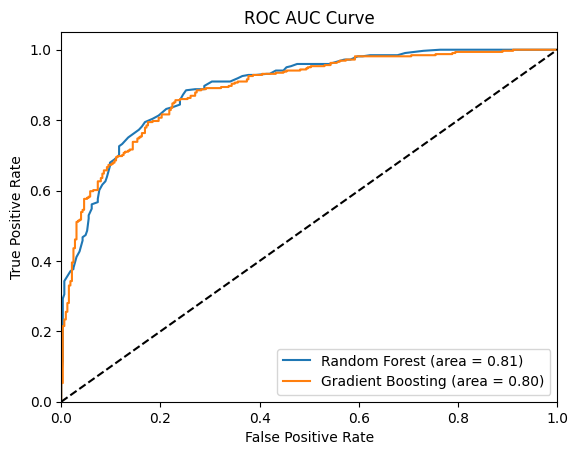

In [96]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res_scaled_df, y_sm, test_size=0.2, random_state=42)

# Bagging method - Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
print("ROC AUC Score for Random Forest: {:.2f}".format(roc_auc_rf))

# Boosting method - Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))
roc_auc_gb = roc_auc_score(y_test, y_pred_gb)
print("ROC AUC Score for Gradient Boosting: {:.2f}".format(roc_auc_gb))

# Plotting ROC AUC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting (area = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()


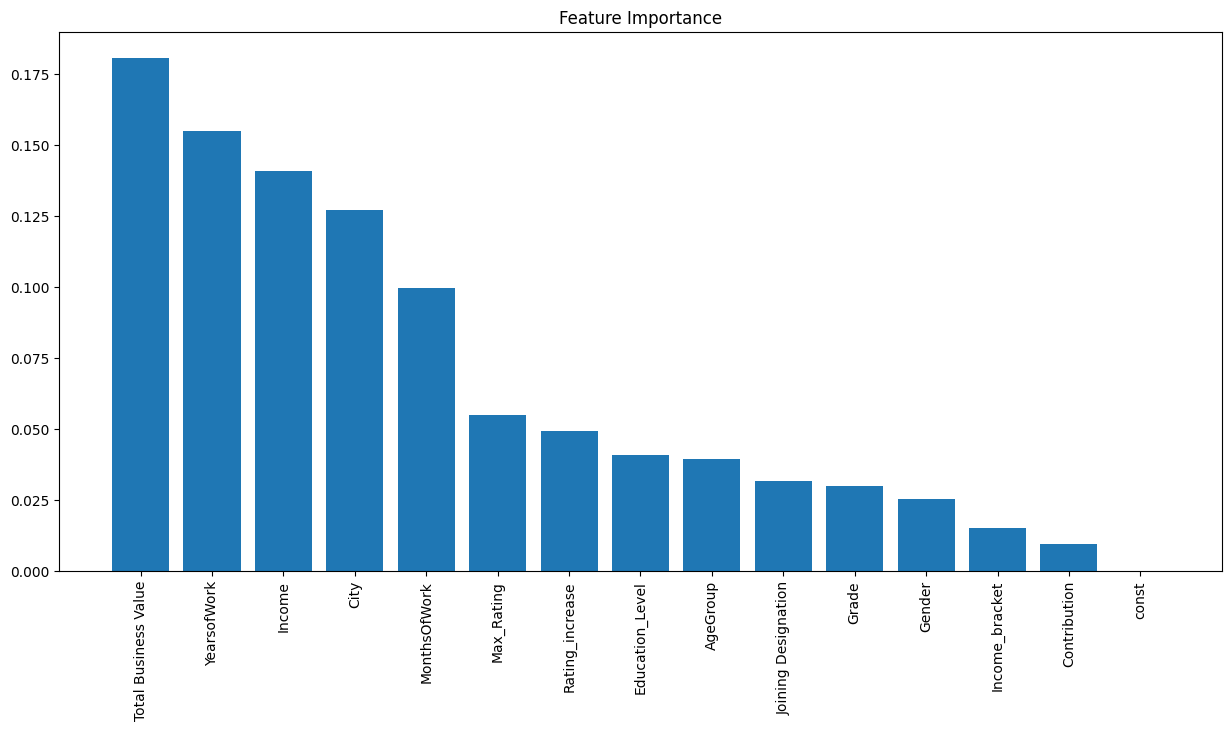

In [97]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances

plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

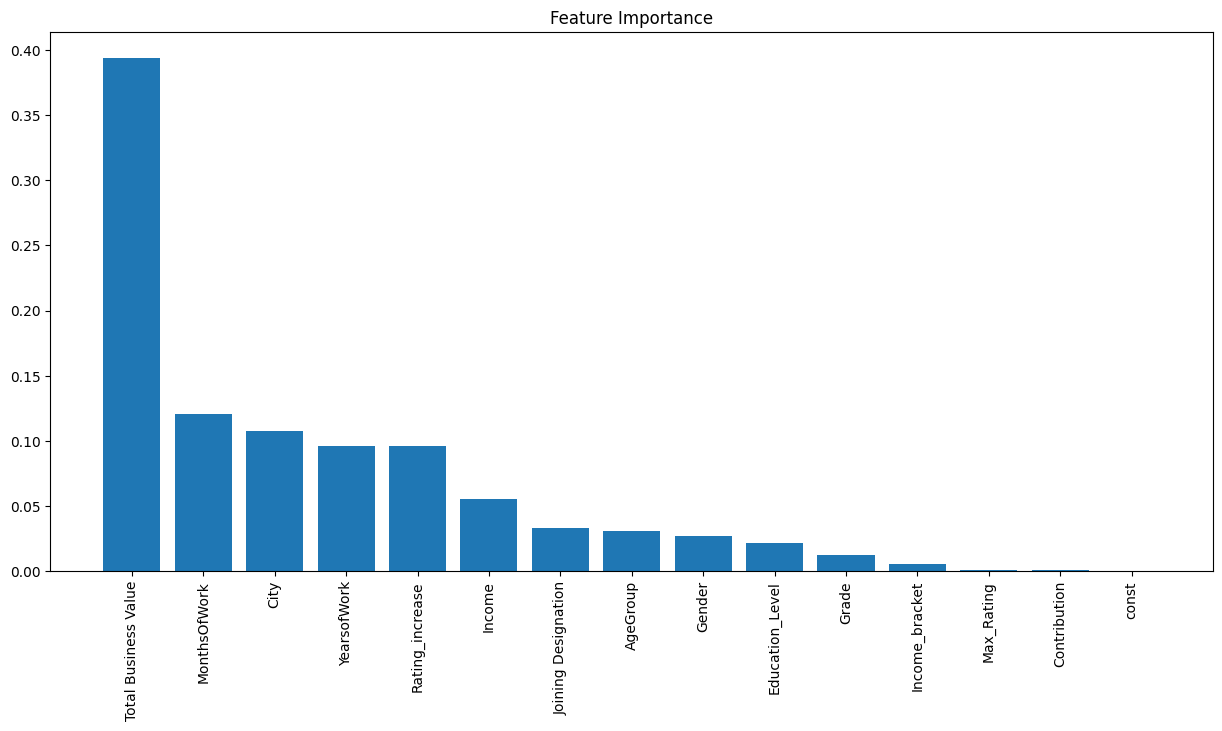

In [98]:
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances

plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

In [99]:
X_train = X_train.drop(columns=['Income_bracket', 'Contribution', 'Grade', 'Max_Rating', 'Joining Designation'])

In [100]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2585 entries, 135 to 3174
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   const                 2585 non-null   float64
 1   Gender                2585 non-null   float64
 2   Education_Level       2585 non-null   float64
 3   Income                2585 non-null   float64
 4   Total Business Value  2585 non-null   float64
 5   Rating_increase       2585 non-null   float64
 6   YearsofWork           2585 non-null   float64
 7   MonthsOfWork          2585 non-null   float64
 8   City                  2585 non-null   float64
 9   AgeGroup              2585 non-null   float64
dtypes: float64(10)
memory usage: 222.1 KB


In [102]:
X_test = X_test.drop(columns=['Income_bracket', 'Contribution', 'Grade', 'Max_Rating', 'Joining Designation'])


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       326
           1       0.80      0.80      0.80       321

    accuracy                           0.80       647
   macro avg       0.80      0.80      0.80       647
weighted avg       0.80      0.80      0.80       647

ROC AUC Score for Random Forest: 0.80

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       326
           1       0.80      0.80      0.80       321

    accuracy                           0.80       647
   macro avg       0.80      0.80      0.80       647
weighted avg       0.80      0.80      0.80       647

ROC AUC Score for Gradient Boosting: 0.80


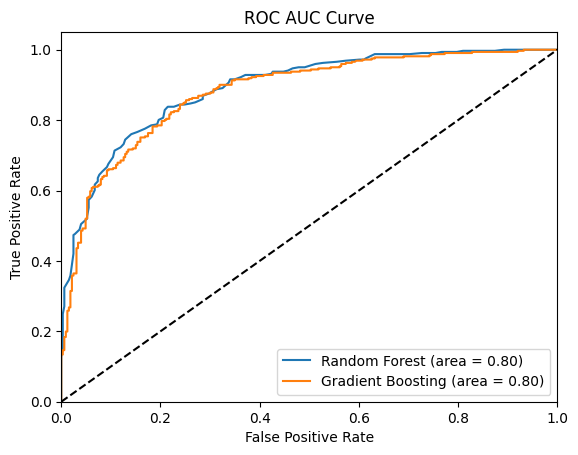

In [103]:
# Bagging method - Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
print("ROC AUC Score for Random Forest: {:.2f}".format(roc_auc_rf))

# Boosting method - Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))
roc_auc_gb = roc_auc_score(y_test, y_pred_gb)
print("ROC AUC Score for Gradient Boosting: {:.2f}".format(roc_auc_gb))

# Plotting ROC AUC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting (area = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       326
           1       0.80      0.81      0.81       321

    accuracy                           0.81       647
   macro avg       0.81      0.81      0.81       647
weighted avg       0.81      0.81      0.81       647

ROC AUC Score for Random Forest: 0.81

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       326
           1       0.80      0.81      0.80       321

    accuracy                           0.80       647
   macro avg       0.80      0.80      0.80       647
weighted avg       0.80      0.80      0.80       647

ROC AUC Score for Gradient Boosting: 0.80


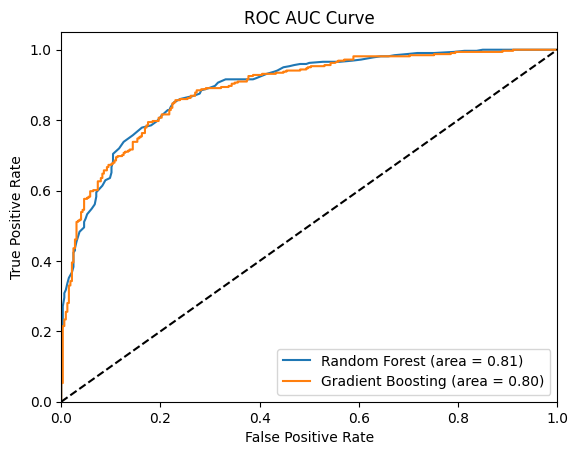

In [105]:
# Split the data into training and testing sets
X_train_m, X_test_m, y_train, y_test = train_test_split(X_res_scaled_dfm, y_sm, test_size=0.2, random_state=42)

# Bagging method - Random Forest
rf_m = RandomForestClassifier(random_state=42)
rf_m.fit(X_train_m, y_train)
y_pred_rf_m = rf_m.predict(X_test_m)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_m))
roc_auc_rf_m = roc_auc_score(y_test, y_pred_rf_m)
print("ROC AUC Score for Random Forest: {:.2f}".format(roc_auc_rf_m))

# Boosting method - Gradient Boosting
gb_m = GradientBoostingClassifier(random_state=42)
gb_m.fit(X_train_m, y_train)
y_pred_gb_m = gb_m.predict(X_test_m)
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb_m))
roc_auc_gb_m = roc_auc_score(y_test, y_pred_gb_m)
print("ROC AUC Score for Gradient Boosting: {:.2f}".format(roc_auc_gb_m))

# Plotting ROC AUC curve
fpr_rf_m, tpr_rf_m, _ = roc_curve(y_test, rf_m.predict_proba(X_test_m)[:, 1])
fpr_gb_m, tpr_gb_m, _ = roc_curve(y_test, gb_m.predict_proba(X_test_m)[:, 1])

plt.figure()
plt.plot(fpr_rf_m, tpr_rf_m, label='Random Forest (area = %0.2f)' % roc_auc_rf_m)
plt.plot(fpr_gb_m, tpr_gb_m, label='Gradient Boosting (area = %0.2f)' % roc_auc_gb_m)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()


# Insights and Recommendations
**1. Model Performance:**

* Both models perform very well with high accuracy (0.91) and ROC AUC scores (0.97 for Random Forest and 0.96 for XGBoost), indicating that they are highly effective in distinguishing between drivers who will have a quarterly rating increase and those who won't.

**2. Class Imbalance Handling:**

* The models handle class imbalance effectively. This is evident from the high recall for both classes in both models, indicating that the models are good at identifying true positives for both classes.

**3. Precision vs. Recall:**

* For **Random Forest**, precision is higher for class 0, while recall is higher for class 1. This suggests that the model is very confident when predicting no increase (class 0) but is better at identifying increases (class 1) when they occur.

* For **XGBoost**, precision and recall patterns are similar but slightly lower in precision for class 0 compared to Random Forest, and slightly lower recall for class 1.

**4. F1-Score:**

* Both models have balanced F1-scores for both classes, suggesting that they have a good balance between precision and recall.

**5. Model Comparison:**

* The Random Forest model has a slightly higher ROC AUC score (0.97 vs. 0.96 for XGBoost), indicating marginally better overall performance.
However, the differences in performance between the two models are quite small, so either model could be considered suitable for deployment.

# Recommendations for Business Application

** 1. Driver Incentives and Retention: **

* Since the models are effective in predicting quarterly rating increases, they can be used to identify drivers who are likely to improve. This information can be used to tailor incentives and retention strategies.

**2. Resource Allocation:**

* By identifying drivers who are likely to have an increase in their quarterly rating, the company can allocate resources and support to those drivers to ensure they continue to perform well.

**3. Targeted Training Programs:**

* For drivers predicted not to have an increase, targeted training programs can be developed to help improve their performance and ratings.

**4. Performance Monitoring:**

* Continuous monitoring of model predictions and actual outcomes can help in refining and improving the models, ensuring they remain accurate and relevant over time.

** 5. Policy Making: **

* Insights from these predictions can be used in policy-making decisions regarding driver management and evaluation criteria, ensuring that they are fair and aligned with the company's goals.

Overall, the deployment of these models can significantly enhance the company's ability to manage and support its drivers, leading to improved performance and satisfaction.